In [1]:
! git clone https://github.com/mrinath123/Deeplense_Gravitational_lensing.git # cloning our repo
! pip install -q timm #cloning timm for pretrained networks
! pip install -q e2cnn #for ecn

Cloning into 'Deeplense_Gravitational_lensing'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 166 (delta 68), reused 125 (delta 40), pack-reused 0
Receiving objects: 100% (166/166), 1.53 MiB | 1.58 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [2]:
!conda install -q -y gdown

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.14  |       ha878542_0         152 KB  conda-forge
    certifi-2022.9.14          |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-4.14.0               |   py37h89c1867_0        1010 KB  conda-forge
    filelock-3.8.0             |     pyhd8ed1ab_0          13 KB  conda-forge
    gdown-4.5.1                |     pyhd8ed1ab_0          17 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.3 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.8.0-pyhd8ed1ab_0
  gdown              conda-forge/noarch::gdown-4.5.1-pyhd8ed1ab_0

The following pa

In [3]:
import timm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm.notebook import tqdm
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import math
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
from transformers import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from sklearn import  model_selection

In [4]:
sys.path.insert(0, './Deeplense_Gravitational_lensing/Lensing_DomainAdaptation')

In [33]:
from e2cnn import gspaces
import e2cnn.nn as e2nn
from models import Encoder , Classifier
from utils import set_seed , SE_HPAMS
from dataset import prep_data,Len , SE_data
from algorithms.self_ensembling import SE_Train,test_func,plot_test_metrics

# Source Data

In [9]:
!gdown http://drive.google.com/uc?id=1cRjseeUQhab5TRRb0NDmFxjGdsd0Fwo0
!gdown http://drive.google.com/uc?id=1MJ-k5xWiww6IFauu7oqqD6mzKfJiMo3r

Downloading...
From: http://drive.google.com/uc?id=1cRjseeUQhab5TRRb0NDmFxjGdsd0Fwo0
To: /kaggle/working/hsc2.zip
100%|████████████████████████████████████████| 621M/621M [01:02<00:00, 9.98MB/s]
Downloading...
From: http://drive.google.com/uc?id=1MJ-k5xWiww6IFauu7oqqD6mzKfJiMo3r
To: /kaggle/working/hsc_lens_smooth.zip
100%|████████████████████████████████████████| 638M/638M [01:05<00:00, 9.69MB/s]


In [10]:
!unzip -q hsc2.zip
!unzip -q hsc_lens_smooth.zip
cls1 = os.listdir("./hsc") # class 1 (non-lensing)
cls2 = os.listdir("./hsc_lens_smooth") # class 2 (lensing)
cls1 = ['./hsc/' + i for  i in cls1 ]
cls2 = ['./hsc_lens_smooth/' + i for  i in cls2]

In [11]:
cls2 = cls2[:400]

In [12]:
X_train, X_val , X_test = prep_data(cls1 , cls2) # first argument is for non-lensing images
X_train.shape , X_val.shape , X_test.shape

((27276, 2), (9093, 2), (4041, 2))

# Target data

In [13]:
!unzip -q -no ../input/lensing-data-xploration/hsc2.zip
!unzip -q -no ../input/lensing-data-xploration/hsc_lens_candidates.zip

caution:  both -n and -o specified; ignoring -o
caution:  both -n and -o specified; ignoring -o


In [14]:
df= pd.read_csv("../input/lensing-data-xploration/Final_csv.csv")

In [15]:
test_df = df[df.fold == 0].reset_index(drop = True)
df = df[df.fold != 0].reset_index(drop = True)

In [16]:
set_seed(42)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
image_size = 64
train_aug = A.Compose(
    [  
        A.RandomCrop(32,32,p=0.5),
         A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),  
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)
val_aug = A.Compose(
    [ 
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

In [19]:
xx = np.concatenate((X_train, df.values[:,:2] ),axis = 0)
np.random.shuffle(xx)

In [20]:
s_data = Len(X_train , train_aug)
t_data = SE_data(xx , train_aug)

test_data = Len(test_df.values , val_aug)

In [21]:
s_loader = DataLoader(s_data, shuffle=True,
                        num_workers=4,
                        batch_size=100,drop_last = True)
t_loader = DataLoader(t_data, shuffle=True,
                        num_workers=4,
                        batch_size=100,drop_last =True)

tv_loader = DataLoader(test_data, shuffle=False,
                        num_workers=4,
                        batch_size=100,drop_last =False)

In [22]:
s_encoder = Encoder(pretrained = True)
s_encoder = s_encoder.to(device)

s_classifier = Classifier()
s_classifier = s_classifier.to(device)


t_encoder = Encoder(pretrained = True)
t_encoder = t_encoder.to(device)

t_classifier = Classifier()
t_classifier = t_classifier.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_ns-00306e48.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b2_ns-00306e48.pth


In [23]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [25]:
hpms = SE_HPAMS()

In [26]:
se_train = SE_Train(s_loader,t_loader ,tv_loader, s_encoder , t_encoder , t_classifier,s_classifier, hpms,OUTPUT_DIR,device)

  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 1/5
loss1 0.7002968816634487
loss2 0.035665162873235255
Total loss 0.7359620446667952


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.7466535932262265
avarage val_auc 0.608599156310987
avarage val_acc 0.12223168654173765


  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 2/5
loss1 0.7006397275801968
loss2 0.0356204265879248
Total loss 0.7362601551062921


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.7451536223368507
avarage val_auc 0.6063658926406464
avarage val_acc 0.1303236797274276


  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 3/5
loss1 0.7003240633536788
loss2 0.035821547272943836
Total loss 0.7361456109758686


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.7459182850953058
avarage val_auc 0.6003404852940079
avarage val_acc 0.12691652470187392


  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 4/5
loss1 0.7001241322825936
loss2 0.03575569228953956
Total loss 0.7358798237846178


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.7449929942162723
avarage val_auc 0.6142897697671705
avarage val_acc 0.12798126064735946


  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 5/5
loss1 0.6998518854379654
loss2 0.036162514116286355
Total loss 0.7360143998966497


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.746188310331949
avarage val_auc 0.6050490807323569
avarage val_acc 0.12734241908006813


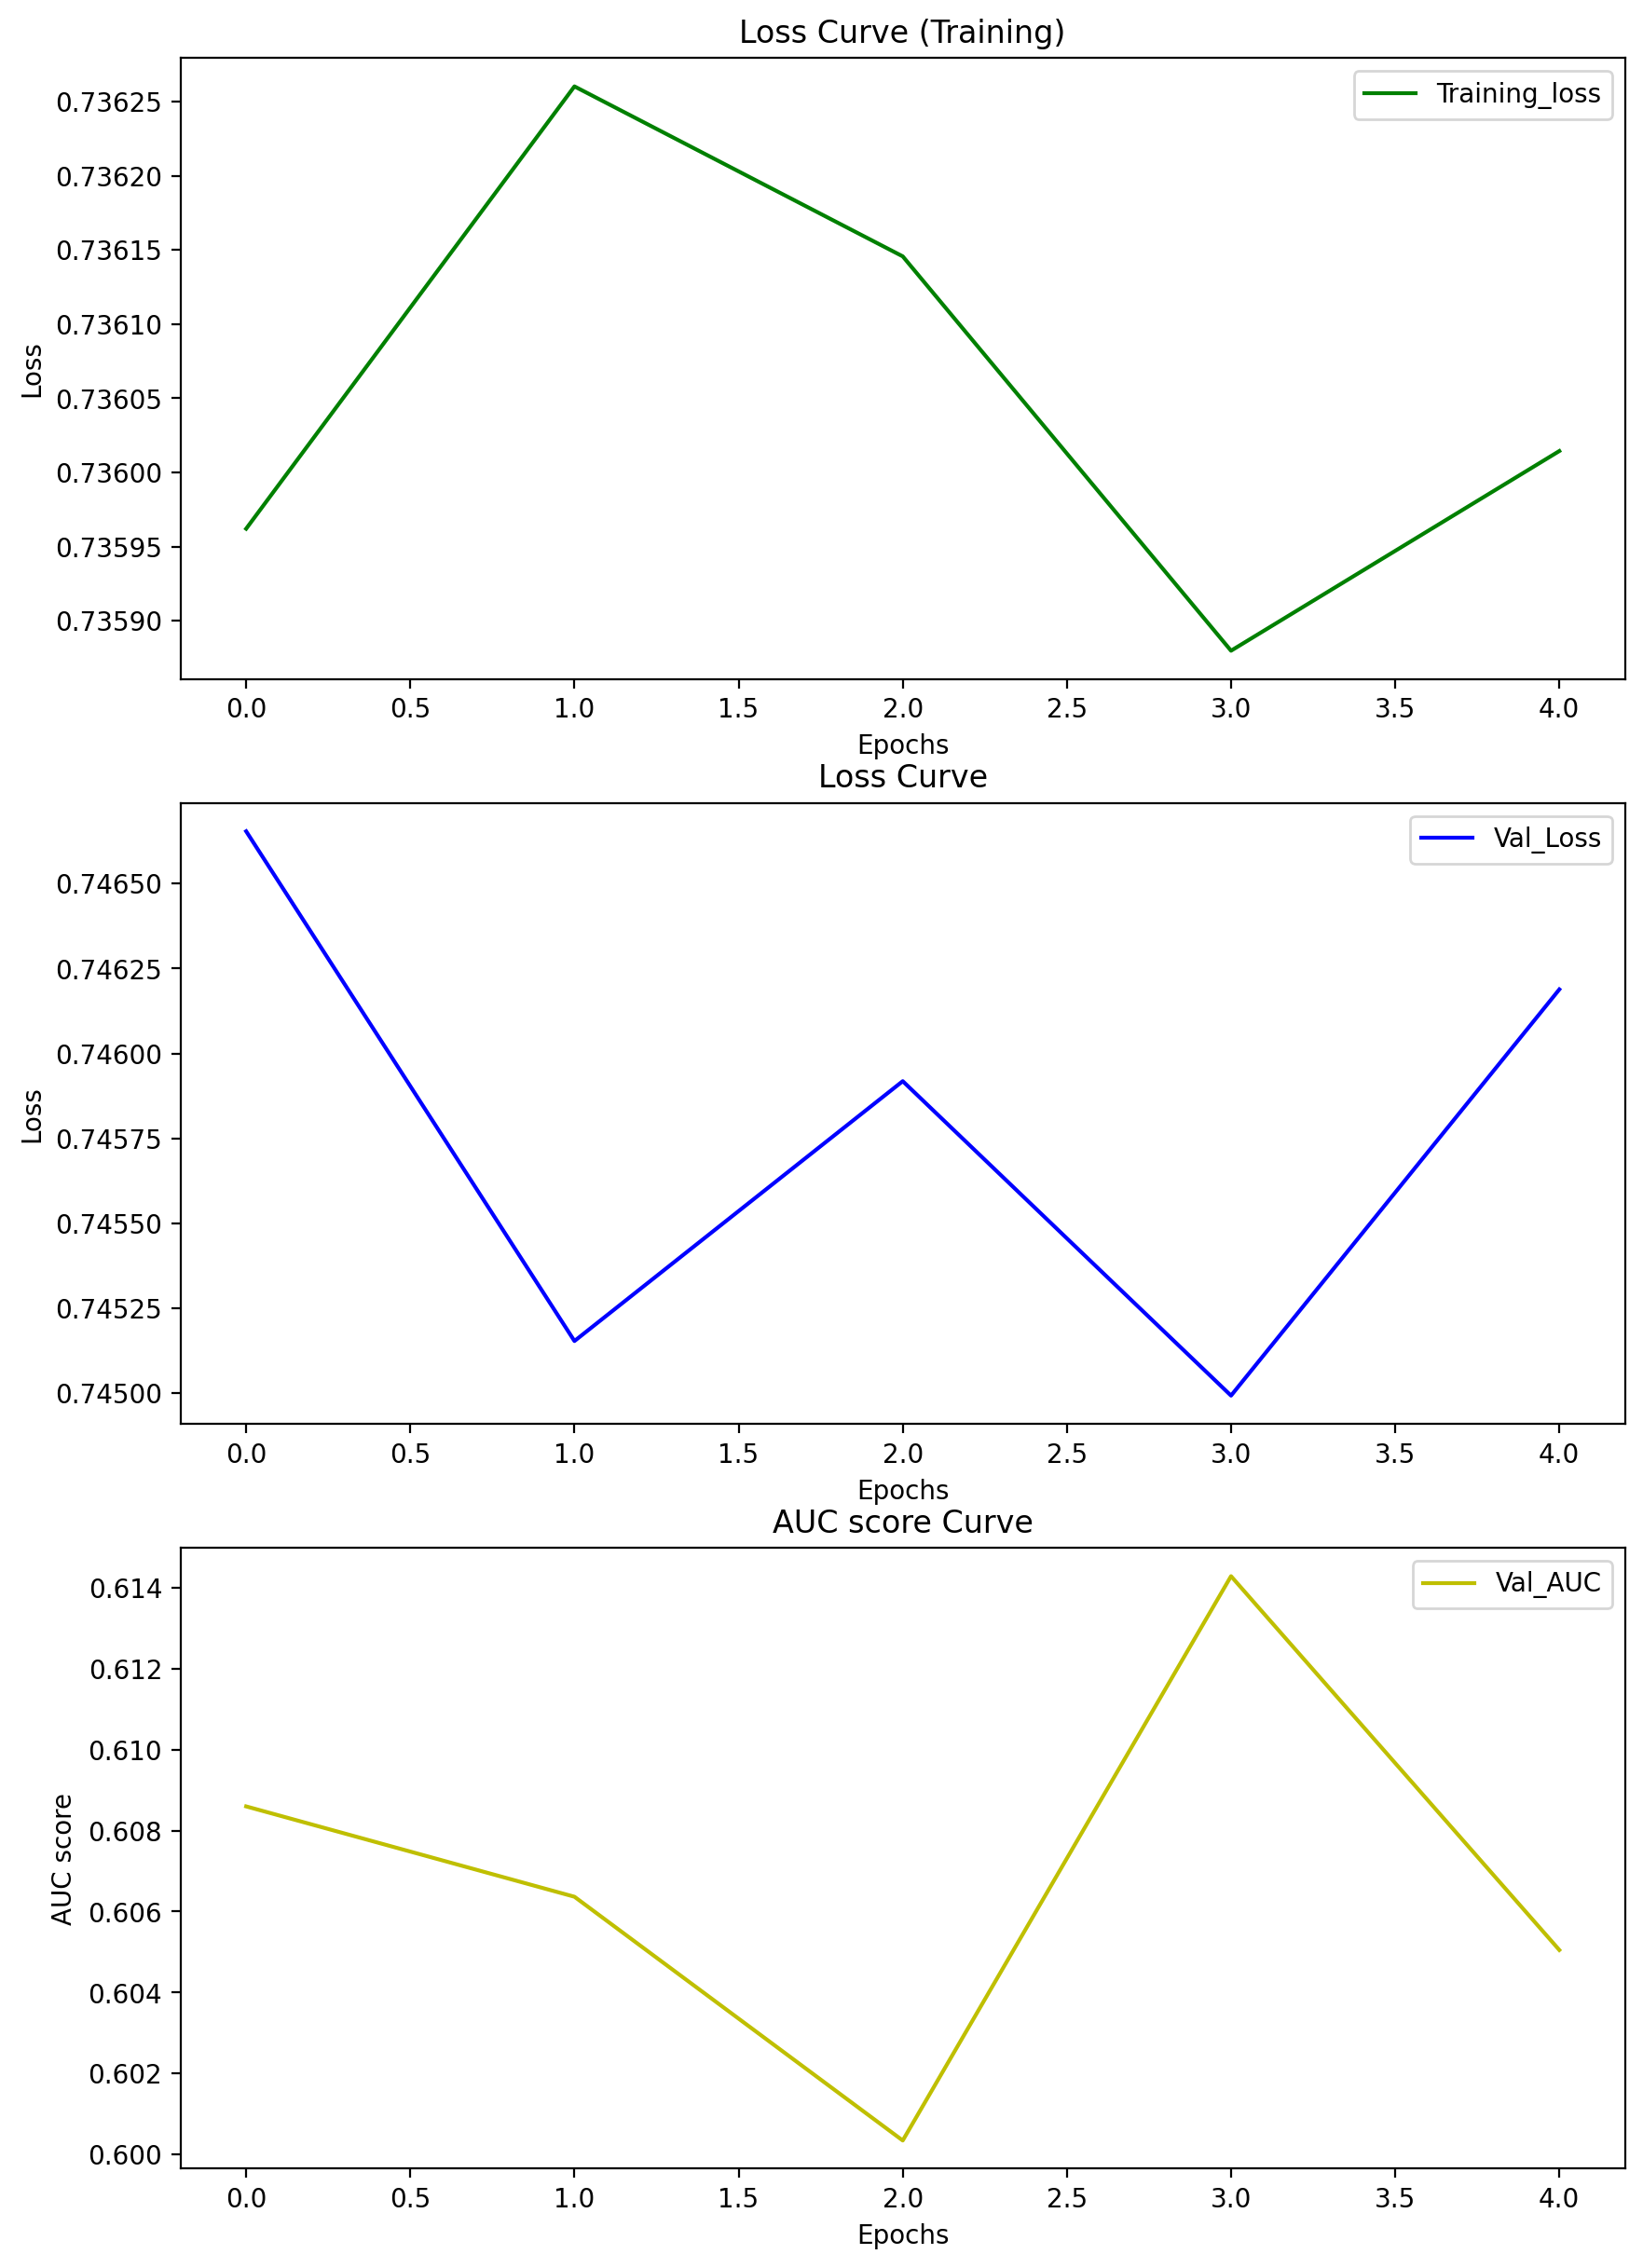

In [27]:
se_train.train()

In [28]:
e_path = './Encoder_val_auc 0.6142897697671705.pth'
c_path = './Classifier_val_auc 0.6142897697671705.pth'

  0%|          | 0/81 [00:00<?, ?it/s]

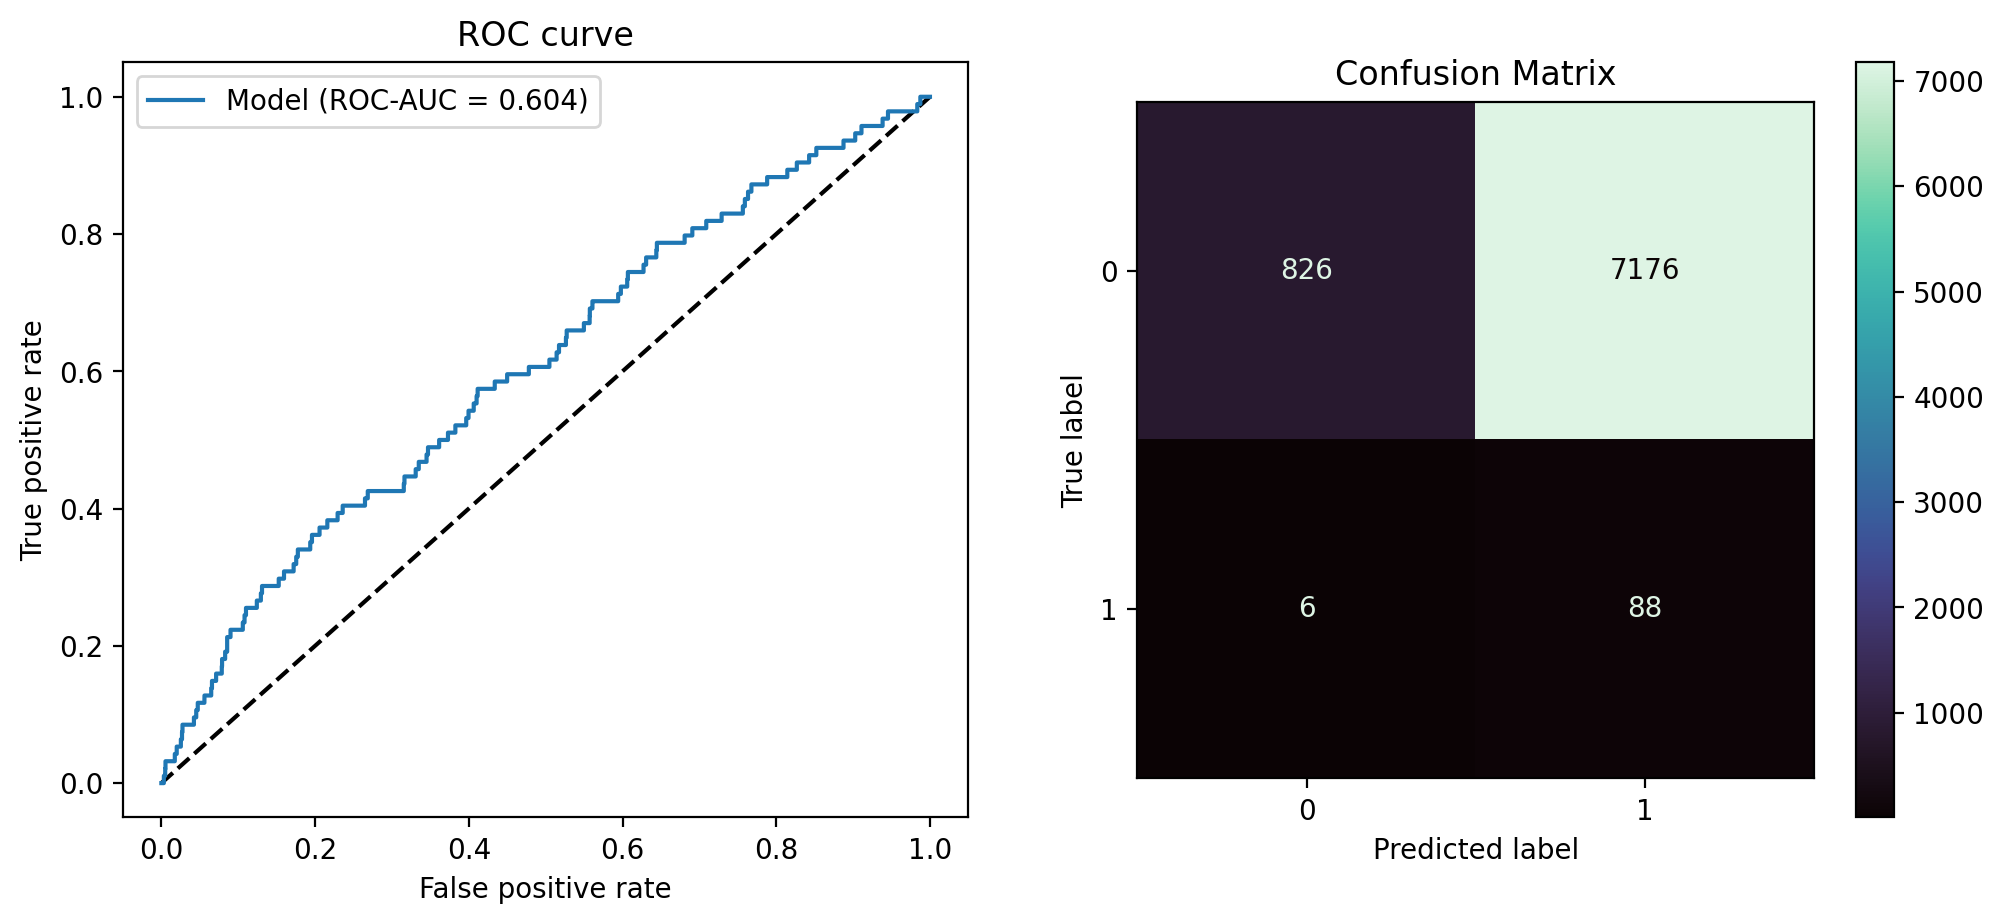

In [34]:
p,t = test_func(t_encoder ,  t_classifier,tv_loader , device, e_path, c_path )
plot_test_metrics(p,t)